In [91]:
import pandas as pd
import jieba
import numpy as np
from pathlib import Path
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM
import matplotlib.pyplot as plt
units = 32

In [92]:
mypath = Path("demo-chinese-text-classification-lstm-keras")

In [93]:
df=pd.read_csv(mypath/'C:\\text_big.csv',header=0, names = ['id','comment','sentiment'])
df.drop('id',axis=1, inplace=True)
df.head()

,comment,sentiment
0,挺好看的，推荐推荐。,1.0
1,影片很值得观看，很有意义,1.0
2,黄渤这种人电影看一部少一部。必须支持,1.0
3,很好看不错的,1.0
4,发的干活吧不回家,1.0


In [94]:
df['text_big'] = df.comment.apply(lambda x: " ".join(jieba.cut(x)))

In [95]:
df.head()

,comment,sentiment,text_big
0,挺好看的，推荐推荐。,1.0,挺 好看 的 ， 推荐 推荐 。
1,影片很值得观看，很有意义,1.0,影片 很 值得 观看 ， 很 有 意义
2,黄渤这种人电影看一部少一部。必须支持,1.0,黄渤 这种 人 电影 看 一部 少 一部 。 必须 支持
3,很好看不错的,1.0,很 好看 不错 的
4,发的干活吧不回家,1.0,发 的 干活 吧 不 回家


In [96]:
df1 = df[['text_big', 'sentiment']]
df1.head()

,text_big,sentiment
0,挺 好看 的 ， 推荐 推荐 。,1.0
1,影片 很 值得 观看 ， 很 有 意义,1.0
2,黄渤 这种 人 电影 看 一部 少 一部 。 必须 支持,1.0
3,很 好看 不错 的,1.0
4,发 的 干活 吧 不 回家,1.0


In [97]:
maxlen = 100
max_words = 10000

In [98]:
#装换成词向量
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.text_big)
sequences = tokenizer.texts_to_sequences(df.text_big)

In [99]:
sequences[:1]

[[24, 4, 2, 1, 123, 123, 3]]

In [100]:
for sequence in sequences[:5]:
    print(len(sequence))

7
8
11
4
6


In [101]:
data = pad_sequences(sequences, maxlen=maxlen)

In [102]:
data

array([[  0,   0,   0, ..., 123, 123,   3],
       [  0,   0,   0, ...,   8,  22, 159],
       [  0,   0,   0, ...,   3, 444,  88],
       ...,
       [  0,   0,   0, ..., 672, 819,   5],
       [  0,   0,   0, ..., 250,   4,   2],
       [  0,   0,   0, ..., 124, 711,   7]])

In [103]:
#词典
word_index = tokenizer.word_index
print(word_index)

{'，': 1, '的': 2, '。': 3, '好看': 4, '了': 5, '不': 6, '！': 7, '很': 8, '看': 9, '电影': 10, '不错': 11, '是': 12, '还': 13, '我': 14, '好': 15, '都': 16, '…': 17, '可以': 18, '没有': 19, '剧情': 20, '吧': 21, '有': 22, '也': 23, '挺': 24, '没': 25, '人性': 26, '就': 27, '太': 28, '真的': 29, '人': 30, '喜欢': 31, '黄渤': 32, '感觉': 33, '什么': 34, '一般': 35, '在': 36, '无聊': 37, '失望': 38, '？': 39, '演技': 40, '还是': 41, '啊': 42, '去': 43, '想': 44, '和': 45, '黄': 46, '渤': 47, '说': 48, '烂片': 49, '垃圾': 50, '一部': 51, '有点': 52, '给': 53, '导演': 54, '就是': 55, '演员': 56, '不是': 57, '搞笑': 58, '觉得': 59, '一点': 60, '难看': 61, '非常': 62, '张艺兴': 63, '这': 64, '一个': 65, '让': 66, '但是': 67, '完': 68, '一出': 69, '喜剧': 70, '知道': 71, '你': 72, '多': 73, '没意思': 74, '、': 75, '好戏': 76, '一般般': 77, '超级': 78, '这个': 79, '但': 80, '值得': 81, '还行': 82, '又': 83, '片子': 84, '故事': 85, '看不懂': 86, '烂': 87, '支持': 88, '睡着': 89, '看到': 90, '到': 91, '王宝强': 92, '意思': 93, '演': 94, '表达': 95, '能': 96, '拍': 97, '情节': 98, '～': 99, '懂': 100, '要': 101, '比较': 102, '真': 103, '这部': 104, '走': 10

In [104]:
labels = np.array(df.sentiment)
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [105]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices] 
labels = labels[indices]

In [106]:
#2&8开
training_samples = int(len(indices) * 0.85)
validation_samples = len(indices) - training_samples

In [107]:
training_samples
#validation_samples

4523

In [108]:
X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples: training_samples + validation_samples]
y_valid = labels[training_samples: training_samples + validation_samples]

In [109]:
myzip = mypath / 'zh.zip'

In [110]:
#词嵌入模型
zh_model = KeyedVectors.load_word2vec_format('zh.vec')

In [111]:
len(zh_model[next(iter(zh_model.vocab))])

300

In [112]:
embedding_dim = len(zh_model[next(iter(zh_model.vocab))])

In [113]:
#以最大长度建立词嵌入矩阵
embedding_matrix = np.random.rand(max_words, embedding_dim)

In [114]:
embedding_matrix

array([[2.05401907e-01, 8.00364513e-01, 4.58358493e-01, ...,
        5.31227534e-01, 5.31767336e-01, 2.01337866e-01],
       [6.30218514e-01, 5.82023239e-01, 1.78218836e-01, ...,
        7.90836456e-01, 5.93759759e-01, 9.09742639e-01],
       [2.72111051e-02, 8.04802562e-01, 8.56765490e-01, ...,
        3.52354714e-01, 9.36853215e-01, 7.19379810e-01],
       ...,
       [7.05362717e-01, 7.94904588e-04, 6.35710929e-01, ...,
        3.66067779e-01, 6.60977277e-01, 3.64152730e-01],
       [2.97406768e-01, 2.22236628e-01, 4.36082622e-01, ...,
        4.93670682e-01, 4.26723276e-02, 7.24366546e-01],
       [1.52137368e-01, 1.73993471e-01, 4.40842203e-01, ...,
        4.27128323e-01, 3.05641053e-01, 5.37264463e-01]])

In [115]:
embedding_matrix = (embedding_matrix - 0.5) * 2

In [116]:
embedding_matrix

array([[-0.58919619,  0.60072903, -0.08328301, ...,  0.06245507,
         0.06353467, -0.59732427],
       [ 0.26043703,  0.16404648, -0.64356233, ...,  0.58167291,
         0.18751952,  0.81948528],
       [-0.94557779,  0.60960512,  0.71353098, ..., -0.29529057,
         0.87370643,  0.43875962],
       ...,
       [ 0.41072543, -0.99841019,  0.27142186, ..., -0.26786444,
         0.32195455, -0.27169454],
       [-0.40518646, -0.55552674, -0.12783476, ..., -0.01265864,
        -0.91465534,  0.44873309],
       [-0.69572526, -0.65201306, -0.11831559, ..., -0.14574335,
        -0.38871789,  0.07452893]])

In [117]:
zh_model.get_vector('的')

array([ 8.6988e-02,  9.1123e-02,  3.0722e-02,  3.4160e-03,  2.7568e-02,
        5.4995e-03,  1.0905e-01,  4.9999e-02, -1.9161e-01,  4.2729e-02,
        1.3284e-01, -4.2997e-02,  4.4196e-02, -4.6042e-02,  5.2395e-02,
       -1.3002e-01,  1.1440e-01, -1.5359e-01,  5.7565e-02,  1.3344e-01,
       -6.4197e-02,  5.3679e-02,  1.3349e-01,  6.1268e-02, -2.4911e-03,
        1.9382e-01,  4.4253e-02, -2.0858e-02, -8.0714e-02,  1.0053e-01,
        5.8553e-02,  6.3155e-02, -2.9961e-02, -3.1906e-02,  5.6153e-02,
        5.1014e-02,  1.0752e-01, -7.4407e-02,  9.1990e-02,  1.7744e-01,
       -5.9959e-02,  1.4046e-01, -8.0201e-02,  4.3989e-02, -9.5205e-02,
        1.3022e-02,  9.1900e-02,  2.4317e-02, -7.0992e-02, -1.5179e-01,
       -3.0031e-02,  1.0344e-01, -5.8155e-02,  3.5950e-02, -5.5085e-02,
        4.7587e-02, -1.4251e-01, -1.3986e-01, -1.3891e-01,  6.9042e-03,
        9.0945e-02, -5.5156e-02,  6.8180e-02,  1.1948e-01,  7.8577e-03,
        1.0014e-01, -4.2805e-02,  2.2362e-01, -2.6212e-02, -3.53

In [118]:
for word, i in word_index.items():
    if i < max_words:
        try:
            embedding_vector = zh_model.get_vector(word)
            embedding_matrix[i] = embedding_vector
        except:
            pass

In [119]:
embedding_matrix

array([[-0.58919619,  0.60072903, -0.08328301, ...,  0.06245507,
         0.06353467, -0.59732427],
       [ 0.26043703,  0.16404648, -0.64356233, ...,  0.58167291,
         0.18751952,  0.81948528],
       [ 0.086988  ,  0.091123  ,  0.030722  , ...,  0.1095    ,
        -0.053695  ,  0.033823  ],
       ...,
       [ 0.41072543, -0.99841019,  0.27142186, ..., -0.26786444,
         0.32195455, -0.27169454],
       [-0.40518646, -0.55552674, -0.12783476, ..., -0.01265864,
        -0.91465534,  0.44873309],
       [-0.69572526, -0.65201306, -0.11831559, ..., -0.14574335,
        -0.38871789,  0.07452893]])

In [120]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim))
model.add(LSTM(units))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,042,657
Trainable params: 3,042,657
Non-trainable params: 0
_________________________________________________________________


In [121]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [122]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_valid, y_valid))
model.save("model1.h5")

Train on 4523 samples, validate on 799 samples
Epoch 1/10
4523/4523 [==============================] - 11s 2ms/step - loss: 0.5492 - acc: 0.7219 - val_loss: 0.4254 - val_acc: 0.8148
Epoch 2/10
4523/4523 [==============================] - 11s 2ms/step - loss: 0.3506 - acc: 0.8545 - val_loss: 0.3326 - val_acc: 0.8461
Epoch 3/10
4523/4523 [==============================] - 10s 2ms/step - loss: 0.2949 - acc: 0.8804 - val_loss: 0.3354 - val_acc: 0.8486
Epoch 4/10
4523/4523 [==============================] - 9s 2ms/step - loss: 0.2540 - acc: 0.8979 - val_loss: 0.3193 - val_acc: 0.8586
Epoch 5/10
4523/4523 [==============================] - 10s 2ms/step - loss: 0.2273 - acc: 0.9087 - val_loss: 0.3009 - val_acc: 0.8761
Epoch 6/10
4523/4523 [==============================] - 10s 2ms/step - loss: 0.2030 - acc: 0.9231 - val_loss: 0.3284 - val_acc: 0.8686
Epoch 7/10
4523/4523 [==============================] - 12s 3ms/step - loss: 0.1834 - acc: 0.9326 - val_loss: 0.3677 - val_acc: 0.8448
Epoch 8/1

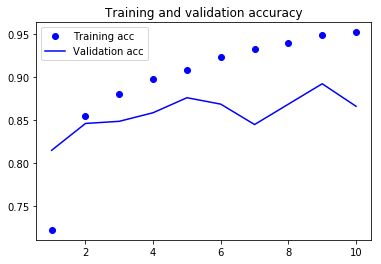

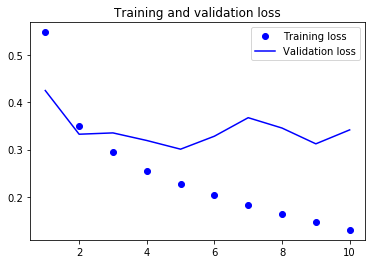

In [123]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#2--->4